In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split,cross_validate,KFold
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB

In [2]:
df = pd.read_csv('googleplaystore.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


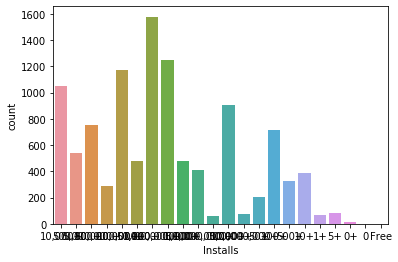

In [3]:
# well distributed
sns.countplot(df['Installs'],data = df)

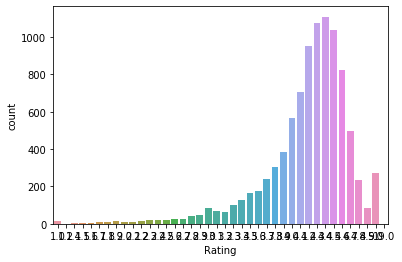

In [4]:
# well distributed
sns.countplot(df['Rating'],data = df)

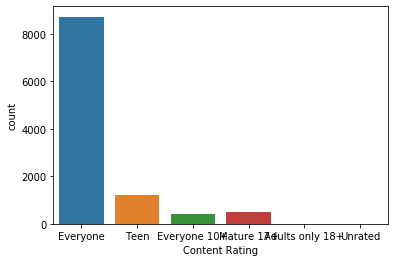

In [5]:
# Adults only only 18 and Unrated are negligible
sns.countplot(df['Content Rating'],data = df)

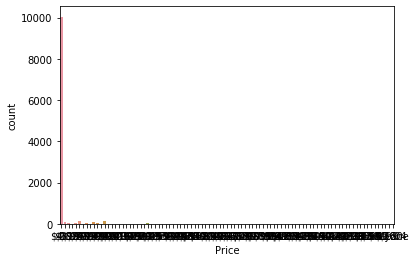

In [6]:
# Price can be replaced with Type
sns.countplot(df['Price'],data = df)

In [7]:
# remove meta data type variables and price (Type is a binary reprrsentation of price)
df.drop(labels = ['Last Updated','Current Ver','Android Ver','Price'], axis = 1, inplace = True)
df.dropna(inplace = True)

# clear size attribute
df['Size'] = df['Size'].map(lambda x: str(round((float(x.rstrip('M'))*10**6), 1)) if x[-1]=='M' else x)
df['Size'] = df['Size'].map(lambda x: str(round((float(x.rstrip('k'))*10**3), 1)) if x[-1]=='k' else x)
df['Size'] = df['Size'].map(lambda x: np.nan if x.startswith('Varies') else x)
df['Size'] = df['Size'].map(lambda x: float(x))
df['Size'].fillna(df.groupby('Category')['Size'].transform('mean'),inplace = True)

# Clear installs
df['Installs'] = df['Installs'].map( lambda x: int(x[:-1].replace(',','')))

# Clear price
# df['Price'] = df['Price'].map(lambda x: float(x.lstrip('$').rstrip()))
# df=df[df['Price']==0]

# Cast reviews
df['Reviews'] = df['Reviews'].map(lambda x: int(x))

# reduce variability in Ratings for better prediction
df['Rating'] = df['Rating'].round(0)

# Remove Unrated and Adults only 18+ as they are neglegible
df = df[df['Content Rating']  != 'Unrated']
df = df[df['Content Rating']  != 'Adults only 18+']

# Split Geners from the ";" and use the first option to club things together
df['Genres'] = df.Genres.str.split(';').str[0]
df['Genres'].replace('Music & Audio', 'Music',inplace = True)

In [8]:
# Linear regression
X=[1,3,4,5,6,7,8]
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,X],df['Rating'],test_size=0.30,random_state=6)
column_trans = make_column_transformer( (OneHotEncoder(),['Category','Type','Content Rating','Genres']),
                                       (StandardScaler(),['Reviews','Size','Installs']))
column_trans.fit_transform(x_train)
model = make_pipeline(column_trans,linear_model.LinearRegression())
fitted_model = cross_validate(model, x_train, y_train, cv=KFold(n_splits=3, random_state=10),scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)
print(fitted_model['train_r2'].mean())
print(fitted_model['test_neg_mean_squared_error'].mean())

0.048270056349925615
-0.3250241972198988


In [9]:
# LogisticRegression is usually used for Classification but can be used for regression for binary data.
# Therefore, we make a dummy variable from Rating callled Rating _b. However, this will predict good and bad only.
df['Rating_b'] = df['Rating'].map( lambda x: 1 if x>2.5 else 0)
X=[3,6,8]
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,X],df['Rating_b'],test_size=0.30,random_state=6)
column_trans = make_column_transformer( (OneHotEncoder(),['Type','Genres']),
                                       (StandardScaler(),['Reviews']))
column_trans.fit_transform(x_train)

model = make_pipeline(column_trans,linear_model.LogisticRegression(random_state=0))
fitted_model = model.fit(x_train,y_train)
predicted = fitted_model.predict(x_test)
print(model.score(x_test,y_test))

0.9850480598077608


C:\Users\narul\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [21]:
# Light gradient boosting regression
import lightgbm as lgb

X=[1,3,4,5,6,7,8]
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,X],df['Rating'],test_size=0.30,random_state=6)
column_trans = make_column_transformer( (OneHotEncoder(),['Category','Type','Content Rating','Genres']),
                                       (StandardScaler(),['Reviews','Size','Installs']))

column_trans.fit_transform(x_train)
evaal={}
model = make_pipeline(column_trans,lgb.LGBMRegressor(boosting_type= 'gbdt',objective="regression",
                                                      learning_rate=0.06, feature_fraction=0.9,
                                                     bagging_fraction=1, bagging_freq=9))
fitted_model = model.fit(x_train,y_train)
predicted = fitted_model.predict(x_test)
print(model.score(x_test,y_test))
# ax=lgb.plot_metric(evaal, metric='l1')
# plt.show()

0.1424828208802278


In [11]:
# loading and merging reviews
df1 = pd.read_csv('googleplaystore_user_reviews.csv')
df1=df1.groupby('App').mean()
df1['Sentiment']=df1['Sentiment_Polarity'].map(lambda x: 'Positive' if x>0 else ('Negative' if x<0 else 'Neutral'))
df=pd.merge(df,df1,on='App',how='left')
df.fillna(method ='ffill', inplace = True)
df.dropna(inplace=True)

In [12]:
# Decision Tree Classification
X=[1,2,3,4,5,6,7,8]
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,X],df['Sentiment'],test_size=0.30,random_state=6)
column_trans = make_column_transformer( (OneHotEncoder(),['Category','Content Rating','Genres']),
                                       (StandardScaler(),['Reviews','Rating','Size','Installs']))

model = make_pipeline(column_trans,DecisionTreeClassifier(criterion = "entropy", random_state = 0))
fitted_model = model.fit(x_train,y_train )
predicted = fitted_model.predict(x_test)
print(model.score(x_test,y_test))

0.6543253826984692


In [13]:
# K neighbours classification
model = make_pipeline(column_trans,KNeighborsClassifier(n_neighbors = 3))
fitted_model = model.fit(x_train,y_train )
predicted = fitted_model.predict(x_test)
print(model.score(x_test,y_test))

0.6771092915628337


0.7475970096119615


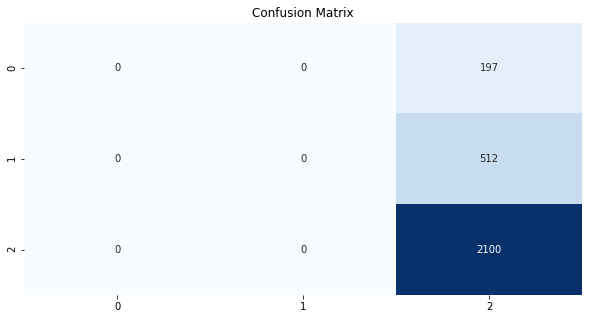

In [20]:
# SVM linear classification 
model = make_pipeline(column_trans,SVC(kernel = 'linear') )
fitted_model = model.fit(x_train,y_train )
predicted = fitted_model.predict(x_test)
print(model.score(x_test,y_test))

plt.figure(figsize=(10,5))
plt.title("Confusion Matrix")
sns.heatmap(confusion_matrix(y_test,predicted),annot=True,cmap="Blues",fmt="d",cbar=False)
plt.show()
